# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-wIzUAwxh-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 70795.10 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 100594.88 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 119466.15 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 131752.46 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 139316.73 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 146507.47 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 72471.25 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 105572.96 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 123174.31 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 130438.57 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 139044.54 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 144947.86 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 16.81 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.74 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.16 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.88 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.66 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.76 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.60 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.60 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.50 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.88 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.52 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.37 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.80 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.74 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.39 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.11 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 48.32 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.31 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.11 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.01 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.06 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 37.37 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.49 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.32 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 49.35 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 48.47 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.91 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.41 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.86 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.02 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 36.02 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 16.89 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 27.84 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 35.32 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 40.37 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 43.92 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 45.55 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 44.57 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.46 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.67 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.61 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.42 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.61 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.76 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.10 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.56 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.68 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.43 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.31 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 37.91 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.82 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.99 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.25 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.86 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 48.03 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.64 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.50 examples/s]

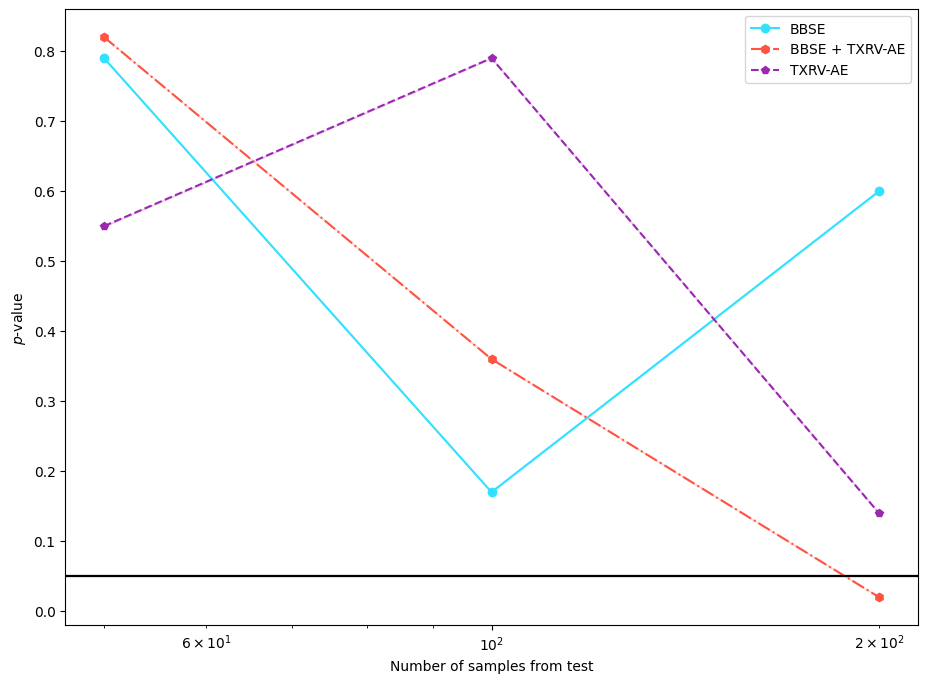

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.66 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.41 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.03 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.62 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.24 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.68 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.39 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.57 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.65 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.99 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.86 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.44 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.80 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.81 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.27 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.95 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.48 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 54.09 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.70 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.35 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.95 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.90 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 50.14 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 55.52 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.63 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 57.35 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.01 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.05 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.04 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.95 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.32 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.55 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.19 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.36 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.03 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.37 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.39 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.19 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.37 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.22 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.09 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.77 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.73 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.18 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.49 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.90 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.16 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.09 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 32.34 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.82 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.45 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.70 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.67 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.50 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 49.22 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.39 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.02 examples/s]

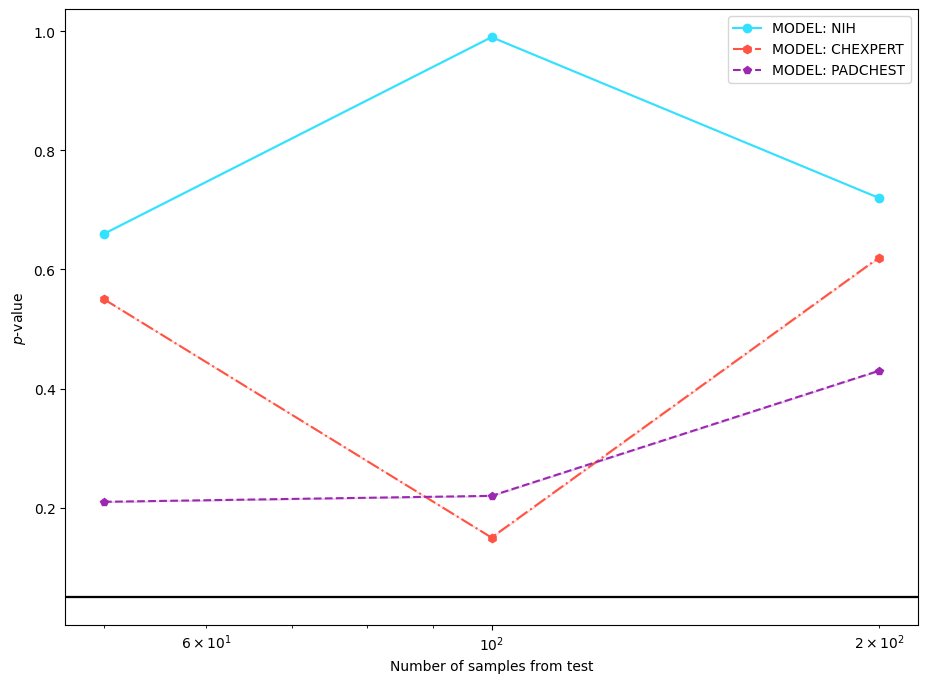

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 54232.49 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 71183.10 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 82846.09 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 95798.32 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 101915.86 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 107128.98 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51405.92 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 74293.73 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 84563.77 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 95888.48 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 103405.20 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 109347.15 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.68 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.48 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.75 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.14 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.47 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.88 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.41 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.16 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.41 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.21 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 32.26 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.43 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.52 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.56 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.90 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.28 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.71 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.48 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.74 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52903.74 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 74391.93 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 87902.00 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 100600.95 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 114898.50 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 58057.15 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 83290.73 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 96355.72 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 102617.39 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 106958.51 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 111000.35 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.34 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.25 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.69 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.30 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.20 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.17 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.52 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.23 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.47 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.20 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.91 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.81 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 18.96 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.21 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.57 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.87 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.54 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.47 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.16 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 54885.30 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 73433.43 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 89531.75 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 98047.09 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 103410.44 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 108418.73 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52017.45 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 72077.78 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 85954.27 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 97092.62 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 100910.44 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 110990.25 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.91 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.81 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.83 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 50.24 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 55.49 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.79 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 57.10 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.91 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.10 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 19.00 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.47 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.92 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.19 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.50 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.95 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.70 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.33 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.16 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.92 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 60978.26 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 86073.62 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 97970.21 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 105517.06 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 109491.52 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 113415.27 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 55796.22 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 79710.20 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 94269.60 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 103413.98 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 113073.65 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 116366.13 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.58 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.25 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 42.49 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 49.92 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 54.97 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.27 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.74 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.74 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.75 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.52 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 31.40 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 40.54 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.13 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.20 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.80 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.07 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.54 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.62 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.50 examples/s]

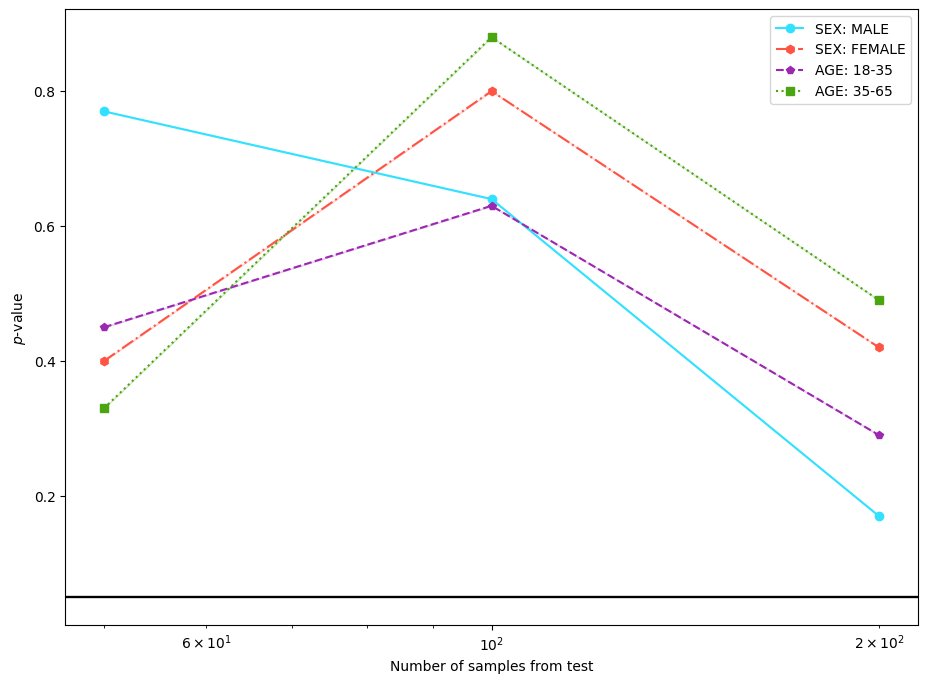

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:08, 19.86 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 33.76 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 43.53 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 50.46 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 55.39 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 58.17 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 57.42 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.04 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.56 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.20 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.64 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.73 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.68 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.16 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.01 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.94 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.59 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.34 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.60 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.12 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.24 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.19 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.88 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.77 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.74 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.96 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.21 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.15 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.14 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.37 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.73 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.56 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.75 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.01 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.50 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.97 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.62 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.12 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.50 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.32 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.52 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.59 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.80 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.51 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 28.13 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.06 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.28 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.91 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.30 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.96 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.22 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.09 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.16 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.06 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.32 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.15 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 27.49 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.58 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.78 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 19.40 examples/s]

Map: 100%|██████████| 50/50 [00:01<00:00, 28.08 examples/s]

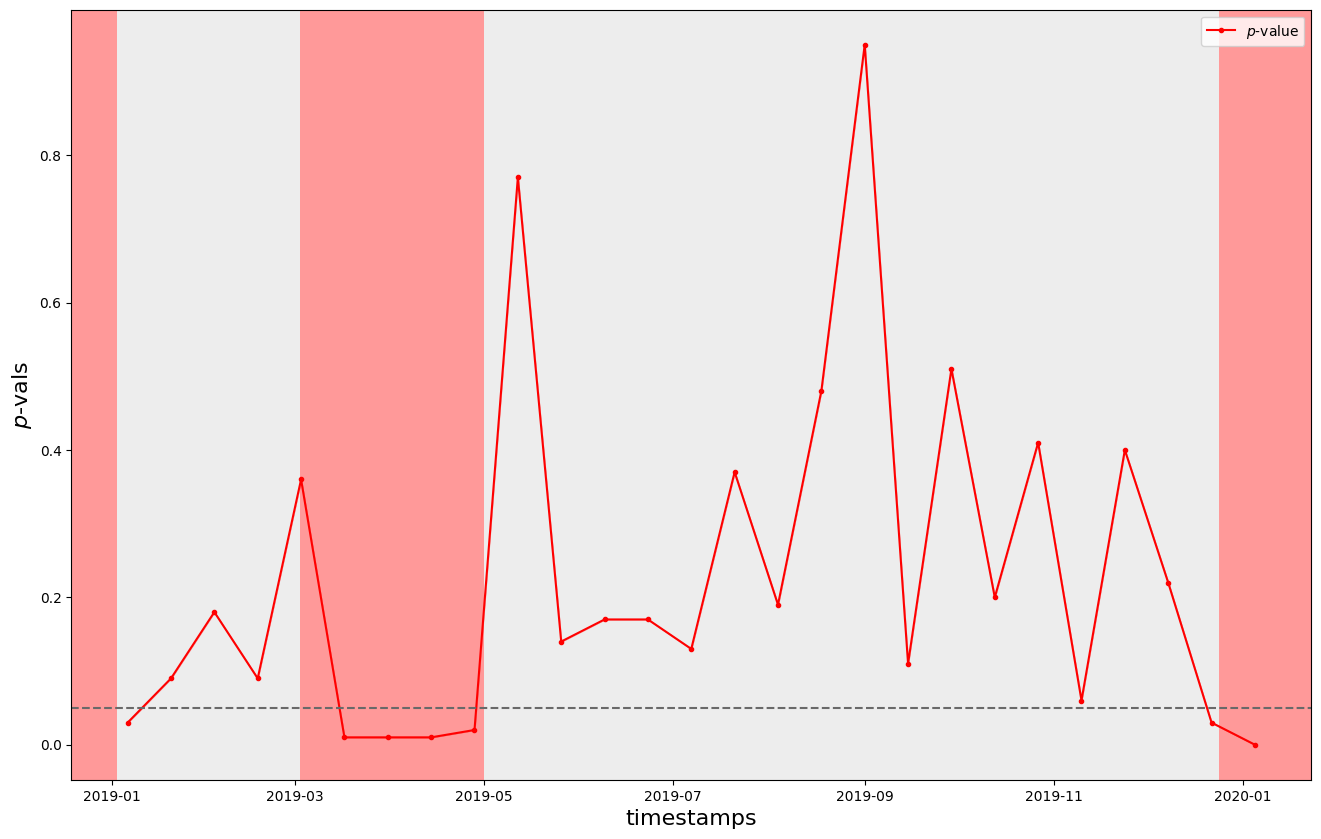

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)